In [1]:
cd ..

/home/sunho/Documents/dev/gorani-reader/backend/dataserver


In [2]:
from gorani.shared import TFJobContext
from gorani.jobs.tfjobs import PrepareTimeDataset
from gorani.jobs.tfjobs.prepare_time_dataset import FEATURE_LEN
import numpy as np

context = TFJobContext()

ps = context.data_db.get_flipped_paragraphs(1)

job = PrepareTimeDataset(context)
x,y = job.transform_paragraphs(ps)
print(len(x), len(y))

125 125


In [3]:
idx = np.where(y > 200)
print(len(idx))
x = np.delete(x, idx, axis=0)
y= np.delete(y, idx, axis=0)
print(x.shape, y.shape)
print(x.dtype, y.dtype)

2
(122, 346, 44) (122, 1)
float32 float32


In [83]:
print([' '.join([word['word'] for word in p['paragraph']]) for p in ps])

['” latina ’ s face truly looked happy as he said those words and suddenly hugged her . if this were a plot to make me drop the matter , then that ’ d be an ominous premonition ... but if it were an ugly , wicked woman who was trying to deceive me , it would be no problem ! if this were a plot to make me drop the matter , then that ’ d be an ominous premonition ... but if it were an ugly , wicked woman who was trying to deceive me , it would be no problem ! regardless of these ridiculous thoughts , dale seemed to be truly blissful at this moment .', 'feeling dale ’ s palm on her back , her eyes shot open , and she responded with a serious look of determination on her face . “ latina will give it her all . she ’ ll be here with rita and kenneth . so please , come back . “ right , and i ’ ll bring a souvenir back with me . so take care , and watch the place for me . he gave her one last , firm hug and set her down . when they reached the entrance to the shop , kenneth took charge of lati

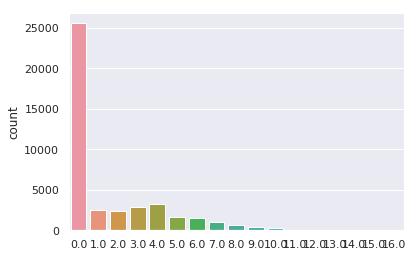

In [84]:
import seaborn as sns
sns.set(color_codes=True)
sns.countplot(x[:, :, FEATURE_LEN - 1].flatten())

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, shuffle= True)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)
print(x_train.dtype, y_train.dtype)
print(FEATURE_LEN)

(97, 346, 44) (97, 1) (25, 346, 44) (25, 1)
float32 float32
44


In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from typing import List
import datetime

def experiment(neurons: List[int], dropouts: List[float]):
    for neuron in neurons:
        for dropout in dropouts:
            start = datetime.datetime.now()
            val_loss = train(FEATURE_LEN, neuron, dropout)
            print('{}-{}'.format(neuron, dropout), ':', val_loss)
            end = datetime.datetime.now()
            elapsed = end - start
            print(elapsed.seconds,".",elapsed.microseconds) 
            
def train(feature_len: int, neuron: int, dropout: float):
    with tf.Graph().as_default():
        with tf.Session() as sess:
            K.set_session(sess)
            model = Sequential()
            model.add(GRU(neuron, input_shape=(None, feature_len), dropout=dropout, recurrent_dropout=dropout, kernel_initializer='he_uniform'))
            model.add(Dense(neuron, activation='relu'))
            model.add(Dense(1))
            model.compile(loss='mse', optimizer='adagrad')
            day = datetime.date.today().strftime("%I:%M%p on %B %d, %Y")
            filepath = "notebooks/checkpoints/1-time-model-{}-{}-{}.hdf5".format(neuron, dropout, day)
            checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
            tensorboard = TensorBoard(log_dir='notebooks/logs/1-{}-{}-time-model-{}'.format(neuron, dropout, day), histogram_freq=1,
                                      write_graph=True, write_images=False)

            history = model.fit(x_train, y_train, epochs=500, verbose=1, batch_size=10, validation_data=(x_valid, y_valid), callbacks=[checkpoint, tensorboard])
            return min(history.history['val_loss'])
    
experiment([22, 44, 64, 128], [0, 0.2, 0.5])

Train on 97 samples, validate on 25 samples
Epoch 1/500
90/97 [==========================>...] - ETA: 0s - loss: 1818.2319
Epoch 00001: val_loss improved from inf to 1303.91506, saving model to notebooks/checkpoints/1-time-model-22-0-12:00AM on April 05, 2019.hdf5
97/97 [==============================] - 3s 26ms/step - loss: 1783.3766 - val_loss: 1303.9151
Epoch 2/500
90/97 [==========================>...] - ETA: 0s - loss: 1251.6179
Epoch 00002: val_loss improved from 1303.91506 to 1153.96953, saving model to notebooks/checkpoints/1-time-model-22-0-12:00AM on April 05, 2019.hdf5
97/97 [==============================] - 2s 23ms/step - loss: 1292.3113 - val_loss: 1153.9695
Epoch 3/500
90/97 [==========================>...] - ETA: 0s - loss: 1216.3827
Epoch 00003: val_loss improved from 1153.96953 to 1106.23608, saving model to notebooks/checkpoints/1-time-model-22-0-12:00AM on April 05, 2019.hdf5
97/97 [==============================] - 2s 22ms/step - loss: 1212.1684 - val_loss: 1106.23

Epoch 27/500
90/97 [==========================>...] - ETA: 0s - loss: 850.1501
Epoch 00027: val_loss improved from 801.49679 to 794.45289, saving model to notebooks/checkpoints/1-time-model-22-0-12:00AM on April 05, 2019.hdf5
97/97 [==============================] - 2s 23ms/step - loss: 885.3328 - val_loss: 794.4529
Epoch 28/500
90/97 [==========================>...] - ETA: 0s - loss: 822.7949
Epoch 00028: val_loss improved from 794.45289 to 787.54686, saving model to notebooks/checkpoints/1-time-model-22-0-12:00AM on April 05, 2019.hdf5
97/97 [==============================] - 2s 23ms/step - loss: 878.4701 - val_loss: 787.5469
Epoch 29/500
90/97 [==========================>...] - ETA: 0s - loss: 870.1386
Epoch 00029: val_loss improved from 787.54686 to 780.86108, saving model to notebooks/checkpoints/1-time-model-22-0-12:00AM on April 05, 2019.hdf5
97/97 [==============================] - 2s 23ms/step - loss: 871.7590 - val_loss: 780.8611
Epoch 30/500
90/97 [==========================

KeyboardInterrupt: 